# NMF demonstration

This notebook generates an artificial dataset of sketches of a human in different positions.

Each position is generated by the 4 choices for the left and right arm, and the left and right leg, out of 4 possible positions each. This leads to the fact that there are 256 unique positions, but these positions can be generated from just 16 "basis" images, where each image corresponds to the choice of the position for an arm/leg.

It is possible to use nonnegative matrix factorisation to discover this basis.

In [22]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [23]:
from read_data.reading import roll_images, unroll_images

In [24]:
from skimage.draw import line, circle_perimeter

random_offset = 0

def get_random_offset():
    return (random.randint(-random_offset,random_offset), random.randint(-random_offset,random_offset))

def add_body(mat):
    rr, cc = line(25, 32, 46, 32)
    mat[rr, cc] = 1
    rr, cc = circle_perimeter(20, 32, 4)
    mat[rr, cc] = 1
    return mat

def add_right_arm(position, mat):
    return add_left_arm(position, mat[:, ::-1])[:, ::-1]
  

def add_left_arm(position, mat):
    final_pos = [(46, 38), (42, 44), (33, 50), (20, 46)][position]
    offset = get_random_offset()
    rr, cc = line(30, 32, final_pos[0] + offset[0], final_pos[1] + offset[1])
    mat[rr, cc] = 1
    return mat

def add_right_leg(position, mat):
    return add_left_leg(position, mat[:, ::-1])[:, ::-1]

def add_left_leg(position, mat):
    final_pos = [(66, 35), (63, 42), (60, 46), (55, 48)][position]
    offset = get_random_offset()
    rr, cc = line(46, 32, final_pos[0] + offset[0], final_pos[1] + offset[1])
    mat[rr, cc] = 1
    return mat

In [25]:
imsize = (80, 64)

def get_human(la, ll, ra, rl):
    mat = np.zeros(imsize)
    mat = add_body(mat)
    mat = add_left_arm(la, mat)
    mat = add_left_leg(ll, mat)
    mat = add_right_arm(ra, mat)
    mat = add_right_leg(rl, mat)
    
    return mat

def get_random_human():
    mat = np.zeros((80, 64))
    la = random.randint(0, 3)
    ll = random.randint(0, 3)
    ra = random.randint(0, 3)
    rl = random.randint(0, 3)
    
    return get_human(la, ll, ra, rl)

In [26]:
#generate N random images with noise

N = 8000

images = np.array([
    get_random_human() + 0.3 * np.random.rand(*imsize) for i in range(N) 
])

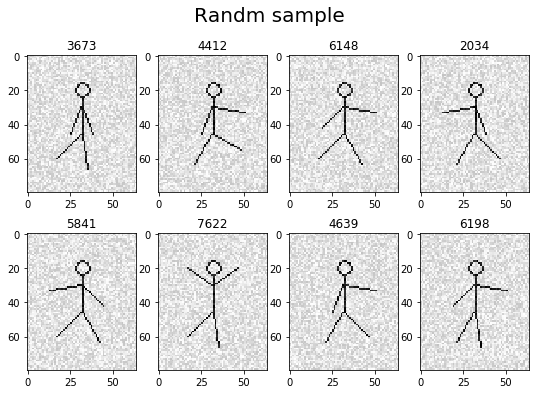

In [27]:
f, axs = plt.subplots(2, 4, figsize=(9,6))
axs = axs.ravel()
f.suptitle("Randm sample", fontsize=20)
for a in axs:
    i = random.randint(0, N)
    a.imshow(images[i], cmap="binary")
    a.set_title(str(i))

# CPU

In [28]:
import nmf.mult
import nmf.pgrad
import nmf.nesterov
import nmf.bayes
import nmf.norms

In [29]:
unrolled_data, original_shape = unroll_images(images)

In [30]:
unrolled_data.shape # N 80x64 images

(8000, 5120)

In [31]:
def plot_results(V, W, H, original_shape):
    norm =  nmf.norms.norm_Frobenius(V - W @ H)
    
    basis = roll_images(H, original_shape)

    f, axs = plt.subplots(3, 6, figsize=(16,11))
    
    f.suptitle("Basis images, Frobenius norm of (original - reconstructed from factorisation) is {:.2f}".format(
        norm), fontsize=20)
    
    axs = axs.ravel()

    for i, (a, im) in enumerate(zip(axs, basis)):
        a.imshow(im, cmap="binary")
        a.set_title(str(i))

    axs[-1].set_axis_off()
    axs[-2].set_axis_off()

In [32]:
time_limit = 10
factor_size = 16

### Multiplicative NMF algorithm

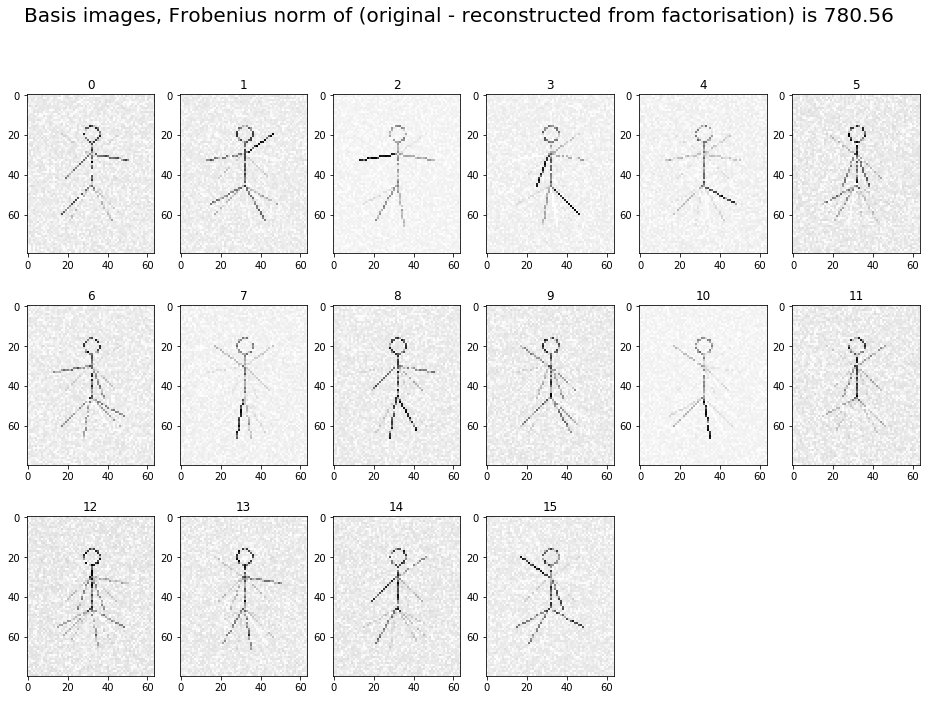

In [33]:
W, H = nmf.mult.factorise_Fnorm(unrolled_data, factor_size, time_limit=time_limit, max_steps=10e6)
plot_results(unrolled_data, W, H, original_shape)

### Projected gradient descent NMF

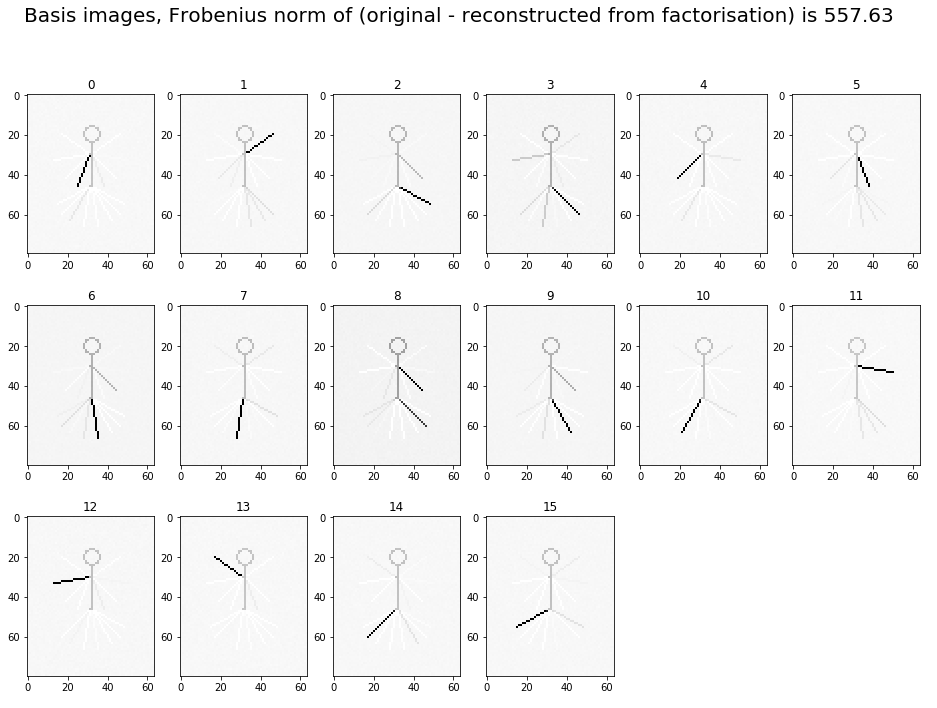

In [34]:
W, H = nmf.pgrad.factorise_Fnorm_subproblems(unrolled_data, 16, time_limit=time_limit, max_steps=10e6)
plot_results(unrolled_data, W, H, original_shape)

### Nesterov gradient descent NMF

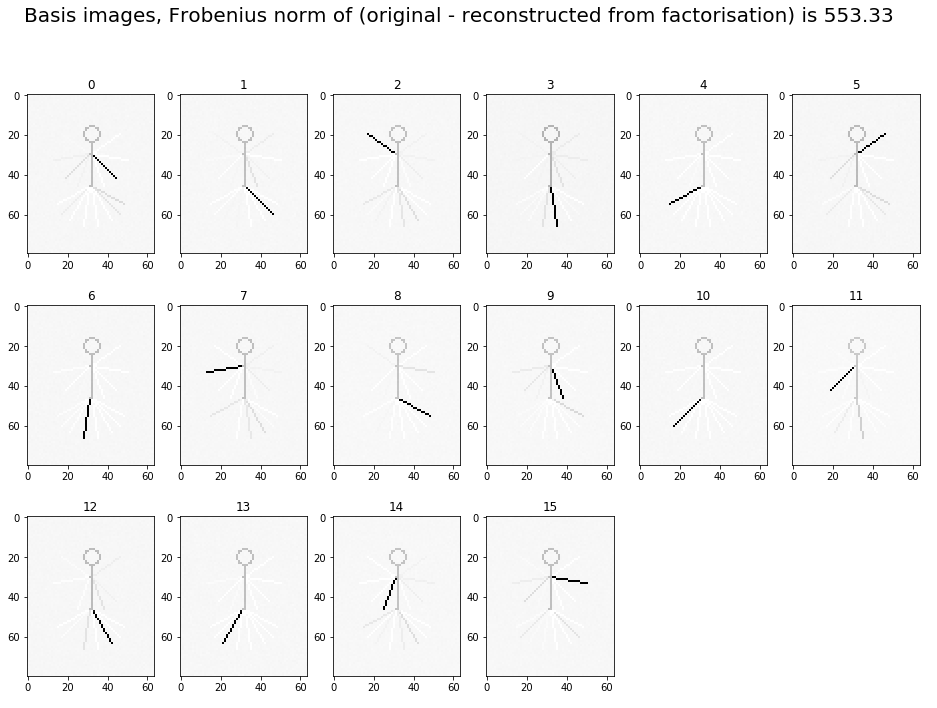

In [35]:
W, H = nmf.nesterov.factorise_Fnorm(unrolled_data, factor_size, time_limit=time_limit, max_steps=10e6)
plot_results(unrolled_data, W, H, original_shape)

### Bayesian NMF (usually a number of basis images turn out ot be zero - lack of robustness)

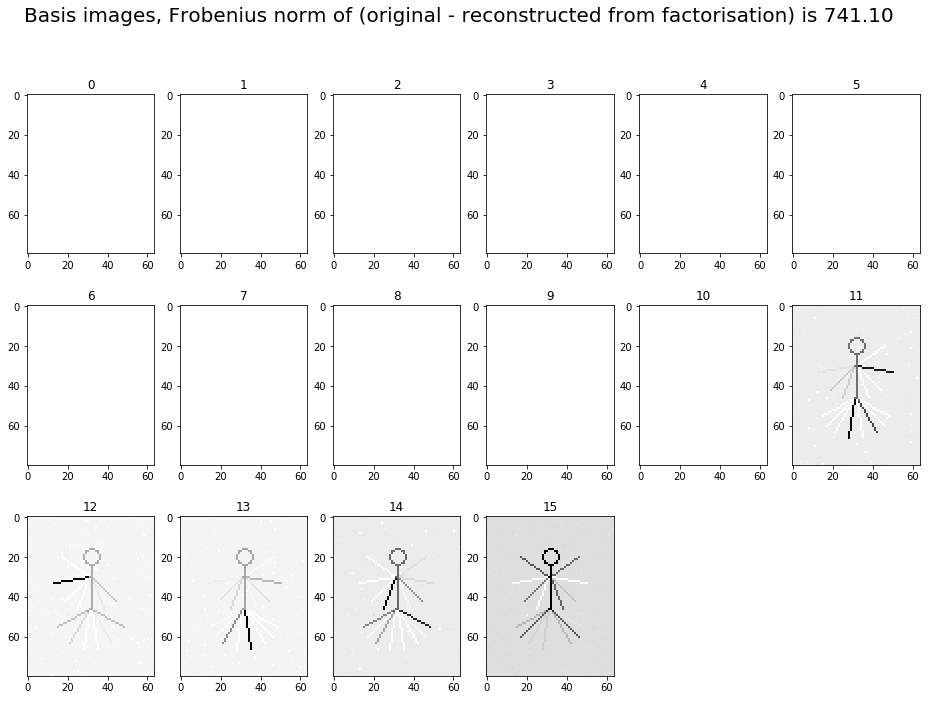

In [36]:
W, H = nmf.bayes.factorise_ICM(unrolled_data, factor_size, time_limit=time_limit, max_steps=10e6)
plot_results(unrolled_data, W, H, original_shape)

# GPU 
### (this senction will work only if GPU is accessible)

In [37]:
import nmf_torch.mult
import nmf_torch.pgrad
import nmf_torch.nesterov
import torch

In [38]:
gpu_data = torch.tensor(unrolled_data).to("cuda")

In [39]:
time_limit = 10
factor_size = 16

### Multiplicative NMF algorithm

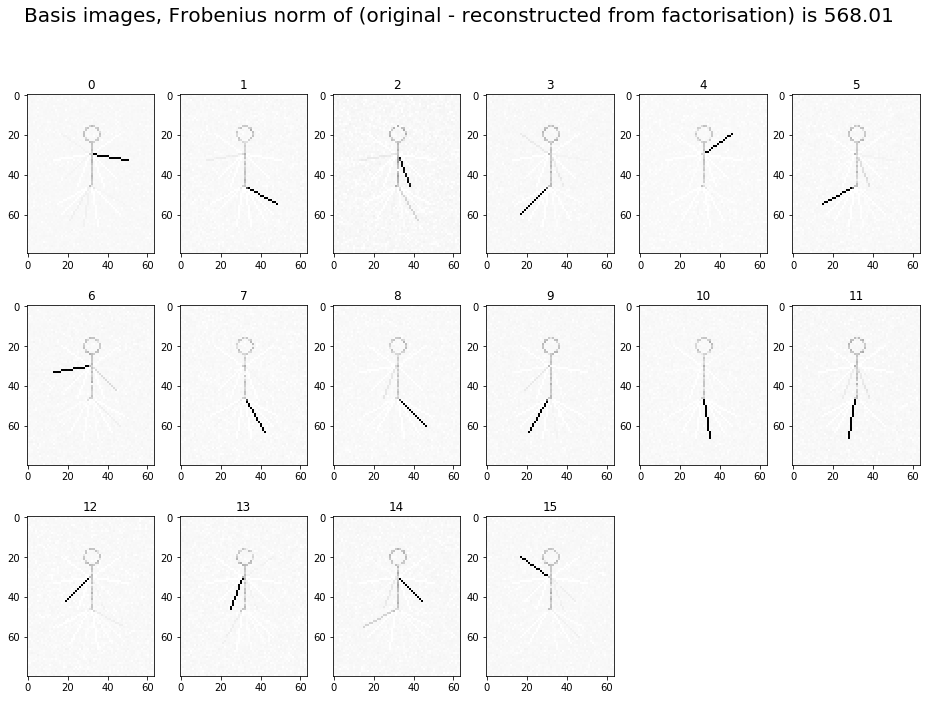

In [40]:
W, H = nmf_torch.mult.factorise_Fnorm(gpu_data, factor_size, time_limit=time_limit, max_steps=10e6)

W = W.to("cpu").numpy()
H = H.to("cpu").numpy()

plot_results(unrolled_data, W, H, original_shape)

### Projected gradient descent NMF

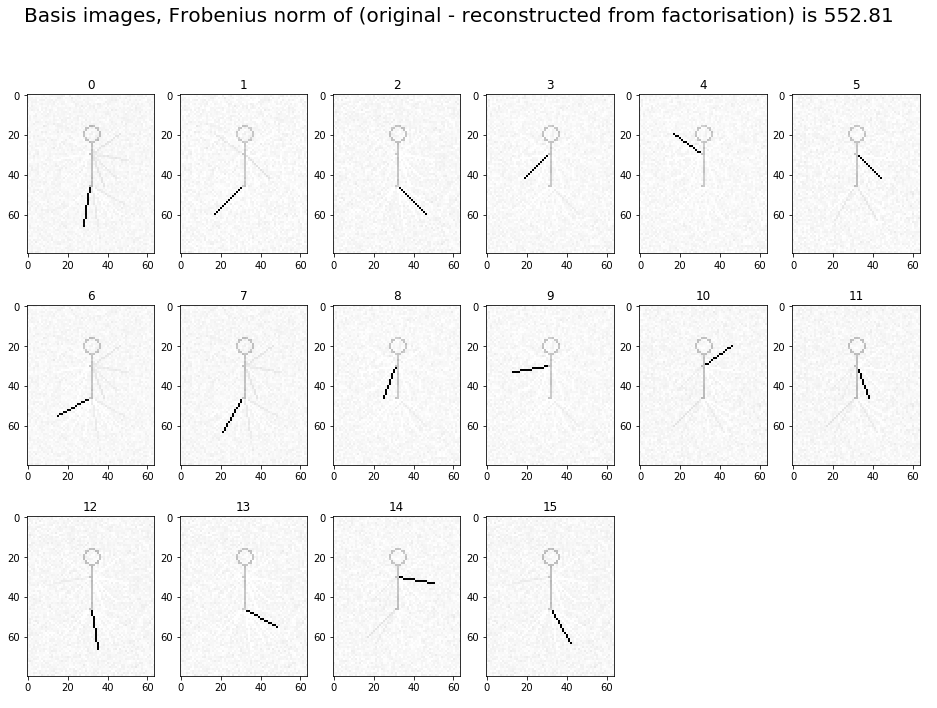

In [41]:
W, H = nmf_torch.pgrad.factorise_Fnorm_subproblems(gpu_data, factor_size, time_limit=time_limit, max_steps=10e6)

W = W.to("cpu").numpy()
H = H.to("cpu").numpy()

plot_results(unrolled_data, W, H, original_shape)

### Nesterov gradient descent NMF

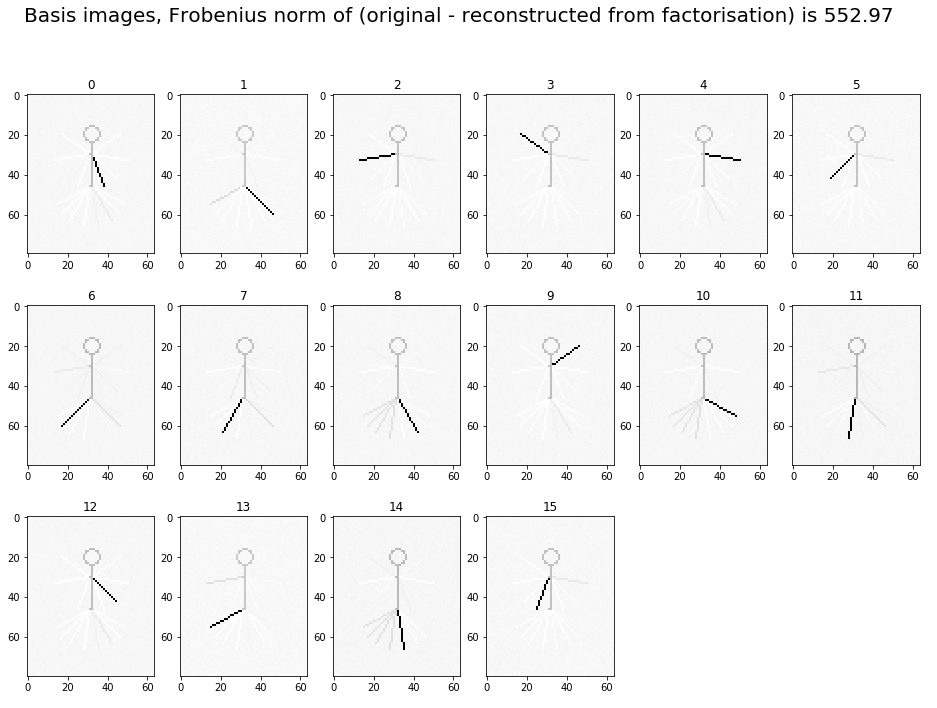

In [42]:
W, H = nmf_torch.nesterov.factorise_Fnorm(gpu_data, factor_size, time_limit=time_limit, max_steps=10e6)

W = W.to("cpu").numpy()
H = H.to("cpu").numpy()

plot_results(unrolled_data, W, H, original_shape)